In [1]:
# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf

# Pandas & json
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline

### Set context

In [4]:
# Read credentials
with open('./include/creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [5]:
session

In [6]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "CUSTOMERS"
Schema                      : "PUBLIC"
Warehouse                   : "XSMALL_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 0.11.0


### Data Loading

In [7]:
# customers = pd.read_csv("EcommerceCustomers")
# customers.head()

In [8]:
# # Create a Snowpark DF from the pandas DF
# snowdf = session.createDataFrame(customers)

In [9]:
# snowdf.show(2)

In [10]:
# # Loading customer data from Snowpark DF to a Snowflake internal table

# snowdf.write.mode("overwrite").saveAsTable("customers_new") 

# session.table("CUSTOMERS_NEW").limit(3).show(5)

In [11]:
# # Create a pandas data frame from the Snowflake table
# custdf = session.table('CUSTOMERS_NEW').toPandas() 

# print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

In [12]:
 session.sql("SELECT count(*) FROM customers").collect()

[Row(COUNT(*)=1500)]

In [13]:
custdf = session.table("customers")

In [14]:

custdf=custdf.to_pandas()
type(custdf)

pandas.core.frame.DataFrame

In [15]:
custdf.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


### Model Training & Testing

<AxesSubplot:title={'center':'Encoded Correlation Heatmap for Used Vehicles Dataset'}>

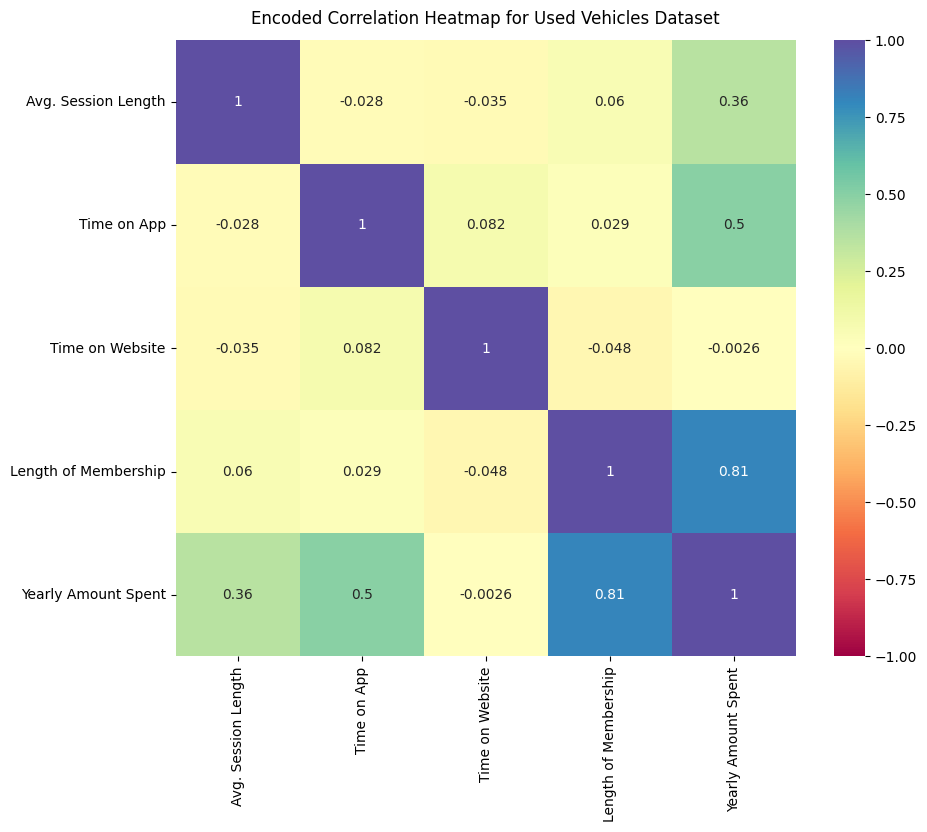

In [16]:
# Start by understanding the correlation matrix for the new data frame
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Encoded Correlation Heatmap for Used Vehicles Dataset', pad=12)
sns.heatmap(custdf.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')

In [17]:
# Define X and Y for modeling
X = custdf[['Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership']]
Y = custdf['Yearly Amount Spent']

In [18]:
# Split into training & Testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                 test_size=0.3, random_state=101)

#### Linear Regression - Predict Yearly Spend

In [19]:
# Create an instance of Linear Regression and Fit the training datasets
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [20]:
# Creating a User Defined Function within Snowflake to do the scoring there
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:
    return pd.Series(lm.predict(df))  

linear_model_vec = pandas_udf(func=predict_pandas_udf,
                                return_type=FloatType(),
                                input_types=[FloatType(),FloatType(),FloatType(),FloatType()],
                                session=session,
                                packages = ("pandas","scikit-learn"), max_batch_size=200)

In [21]:

# Calling the UDF to do the scoring (pushing down to Snowflake)
output = session.table('CUSTOMERS').select(*list(X.columns),
                    linear_model_vec(list(X.columns)).alias('PREDICTED_SPEND'), 
                    (F.col('Yearly Amount Spent')).alias('ACTUAL_SPEND')
                    )

output.show(5)


Passing arguments to a UDF with a list or tuple is deprecated. We still respect this invocation but please consider passing variable-length arguments without a list or tuple.


---------------------------------------------------------------------------------------------------------------------------
|"Avg. Session Length"  |"Time on App"  |"Time on Website"  |"Length of Membership"  |"PREDICTED_SPEND"  |"ACTUAL_SPEND"  |
---------------------------------------------------------------------------------------------------------------------------
|34.49726773            |12.65565115    |39.57766802        |4.082620633             |593.606347698108   |587.951054      |
|31.92627203            |11.10946073    |37.26895887        |2.664034182             |380.5199397170095  |392.2049334     |
|33.00091476            |11.33027806    |37.11059744        |4.104543202             |504.9216595953417  |487.5475049     |
|34.30555663            |13.71751367    |36.72128268        |3.120178783             |570.5743421092327  |581.852344      |
|33.33067252            |12.79518855    |37.5366533         |4.446308318             |591.1444408910966  |599.406092      |
--------

In [22]:
# Save the predicted output as a table on Snowflake
###used later in Streamlit app
output.write.mode("overwrite").saveAsTable("PREDICTED_CUSTOMER_SPEND") 

# Also get a local dataframe to review the results
output=output.toPandas()

##### Plotting and comparing the predicted values with actual spend values

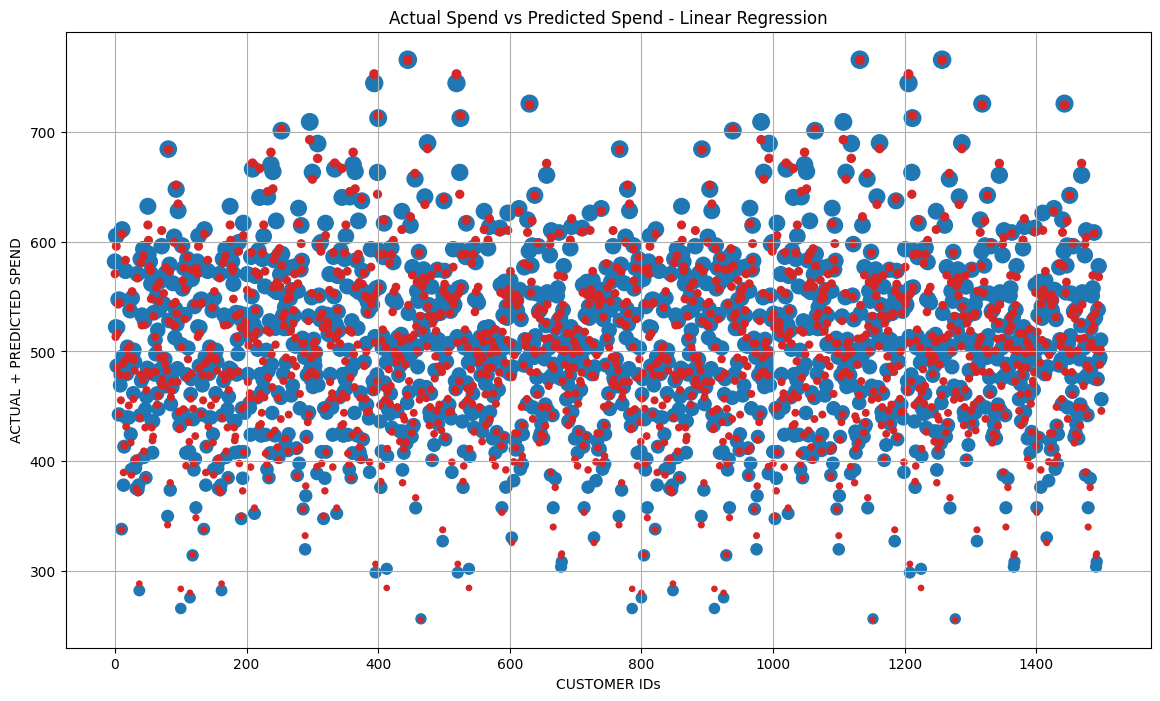

In [23]:
# Plot a descriptive scatter of predicted and actual values
x = output.index
y1 = output["ACTUAL_SPEND"]
y2 = output["PREDICTED_SPEND"]

f, ax = plt.subplots(figsize=(14, 8))
plt.scatter(x, y1, c='tab:blue', s=y1/5)
plt.scatter(x, y2, c='tab:red', s=y2/20)

plt.title(f"Actual Spend vs Predicted Spend - Linear Regression")
plt.ylabel("ACTUAL + PREDICTED SPEND")
plt.xlabel("CUSTOMER IDs")
ax.grid(True)
plt.show()

In [24]:

#1 & 2 Coefficient of Determination (R² & Adjusted R²)
print("\n--- Coefficient of Determination (R²) ---")
r2 = metrics.r2_score(y_pred=y2, y_true=y1)
print(f"R²: {round(r2, 2)}")

#3 & 4. MSE and RMSE
print("\n--- Mean Squared Error (MSE & RMSE) ---")

mse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=True)
rmse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=False)

print(f"MSE: {round(mse, 2)}")
print(f"RMSE: {round(rmse, 2)}")


#5. MAE
print("\n--- Mean Absolute Error (MAE) ---")
mae = metrics.mean_absolute_error(y_pred=y2, y_true=y1)
print(f"MAE: {round(mae, 2)}")



--- Coefficient of Determination (R²) ---
R²: 0.98

--- Mean Squared Error (MSE & RMSE) ---
MSE: 98.67
RMSE: 9.93

--- Mean Absolute Error (MAE) ---
MAE: 7.89


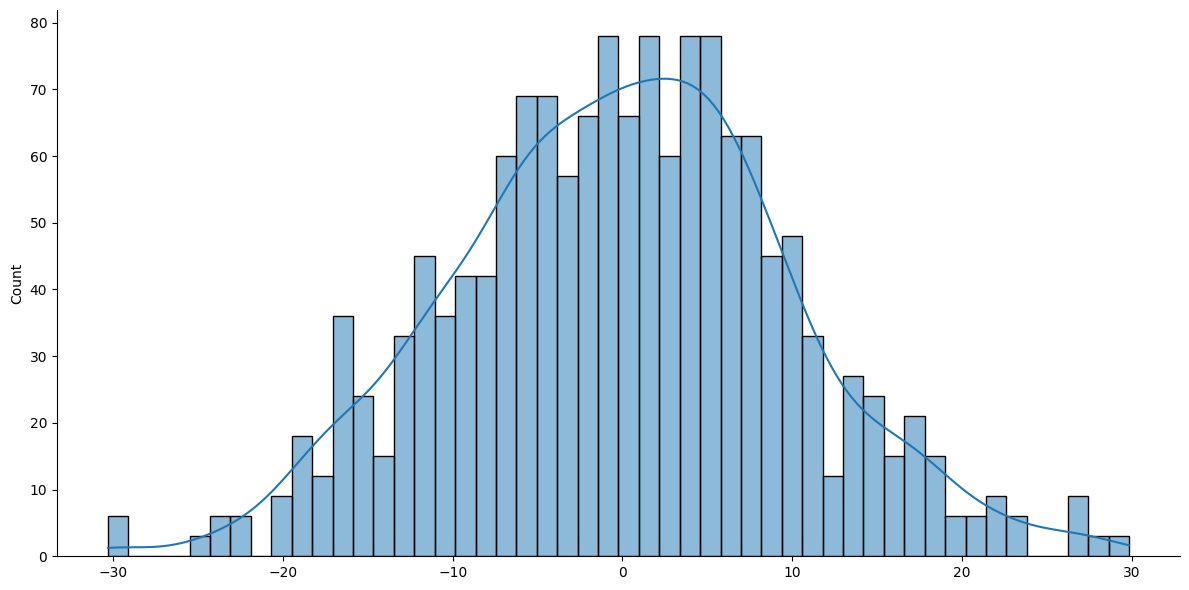

In [25]:
# Distribution of differences between actual and predicted values
# Gaussian kernel density estimate.

sns.displot((y2-y1),bins=50, kde=True, legend=True, height=6, aspect=2);

In [26]:
# Get coefficients from the fitted model
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient']).round(2)
coeff_df


,Coefficient
Avg. Session Length,25.67
Time on App,38.75
Time on Website,0.10
Length of Membership,61.28
